In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.DataFrame(pd.read_csv("./acs2015_census.csv"))
df = df.dropna()
print(df)

       CensusTract        State   County  TotalPop   Men  Women  Hispanic  \
0       1001020100      Alabama  Autauga      1948   940   1008       0.9   
1       1001020200      Alabama  Autauga      2156  1059   1097       0.8   
2       1001020300      Alabama  Autauga      2968  1364   1604       0.0   
3       1001020400      Alabama  Autauga      4423  2172   2251      10.5   
4       1001020500      Alabama  Autauga     10763  4922   5841       0.7   
...            ...          ...      ...       ...   ...    ...       ...   
73996  72153750501  Puerto Rico    Yauco      6205  3291   2914      99.7   
73997  72153750502  Puerto Rico    Yauco      2122   921   1201      99.2   
73998  72153750503  Puerto Rico    Yauco      2277  1097   1180      99.5   
73999  72153750601  Puerto Rico    Yauco      5267  2663   2604      98.8   
74000  72153750602  Puerto Rico    Yauco      2741  1181   1560      99.3   

       White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommut

In [16]:
#df = df[['TotalPop','Native','Hispanic','Asian','Pacific']]
#df = df[['Professional','Service','Office','Construction','Production']]
#df = df[['Drive','Carpool','Transit','Walk','OtherTransp']]
#df = df[['PrivateWork','PublicWork','SelfEmployed','FamilyWork']]
print(df)

       CensusTract        State   County  TotalPop   Men  Women  Hispanic  \
0       1001020100      Alabama  Autauga      1948   940   1008       0.9   
1       1001020200      Alabama  Autauga      2156  1059   1097       0.8   
2       1001020300      Alabama  Autauga      2968  1364   1604       0.0   
3       1001020400      Alabama  Autauga      4423  2172   2251      10.5   
4       1001020500      Alabama  Autauga     10763  4922   5841       0.7   
...            ...          ...      ...       ...   ...    ...       ...   
73996  72153750501  Puerto Rico    Yauco      6205  3291   2914      99.7   
73997  72153750502  Puerto Rico    Yauco      2122   921   1201      99.2   
73998  72153750503  Puerto Rico    Yauco      2277  1097   1180      99.5   
73999  72153750601  Puerto Rico    Yauco      5267  2663   2604      98.8   
74000  72153750602  Puerto Rico    Yauco      2741  1181   1560      99.3   

       White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommut

In [17]:
# Xác định các biến thành phần độc lập và biến giải thích
compositional_cols = ['Professional','Service','Office','Construction','Production']

#data = 
var_target = df['Income']
#family = family[(family != 0).all(axis=1)]

# chuyển dữ liệu thành phần
compositional_data = df[compositional_cols]
#compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()


,Professional,Service,Office,Construction,Production
0,34.7,17.0,21.3,11.9,15.2
1,22.3,24.7,21.5,9.4,22.0
2,31.4,24.9,22.1,9.2,12.4
3,27.0,20.8,27.0,8.7,16.4
4,49.6,14.2,18.2,2.1,15.8


In [18]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = clr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(compositional_data, var_target, test_size=0.2, random_state=42)

# Huấn luyện mô hình hồi quy tuyến tính với kiểm tra chéo
model = LinearRegression()
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')  # Sửa lỗi 'neg_mean_squared_error'

# Huấn luyện mô hình trên toàn bộ tập huấn luyện
model.fit(X_train, y_train)  # Bỏ bước huấn luyện riêng trên tập train

# In ra các tham số của mô hình
print("Độ chặn:", model.intercept_)
print("Hệ số hồi quy:", model.coef_)

Độ chặn: 74029.60717901553
Hệ số hồi quy: [  690.19700421 -1112.49272166  -343.08636123  -278.95997034
  -681.02062092]


In [19]:
# In mô hình ra console
print("CV RMSE scores:", np.sqrt(-cv_scores))
print("Mean CV RMSE:", np.sqrt(-cv_scores).mean())

CV RMSE scores: [19175.14684944 18392.29815416 19187.23827157 19466.41770806
 18860.97281683 19095.92245161 18904.20437652 18695.26323979
 19002.87879817 18928.56945179]
Mean CV RMSE: 18970.891211794486


In [20]:
# Tính tầm quan trọng của các biến
importance = model.coef_
var_importance = pd.DataFrame({'Variables': compositional_cols, 'Importance': importance})
var_importance = var_importance.sort_values(by='Importance', ascending=False)

In [21]:
# Hàm để vẽ tầm quan trọng của các biến
def plot_importance(var_importance):
    var_importance['Rank'] = var_importance['Importance'].rank(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Variables', data=var_importance, palette='coolwarm')
    for index, row in var_importance.iterrows():
        plt.text(row['Importance'], index, f"#{int(row['Rank'])}", color='black', ha="left", va="center")
    plt.title('Relative Variable Importance')
    plt.show()

/tmp/ipykernel_5747/2445877765.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variables', data=var_importance, palette='coolwarm')


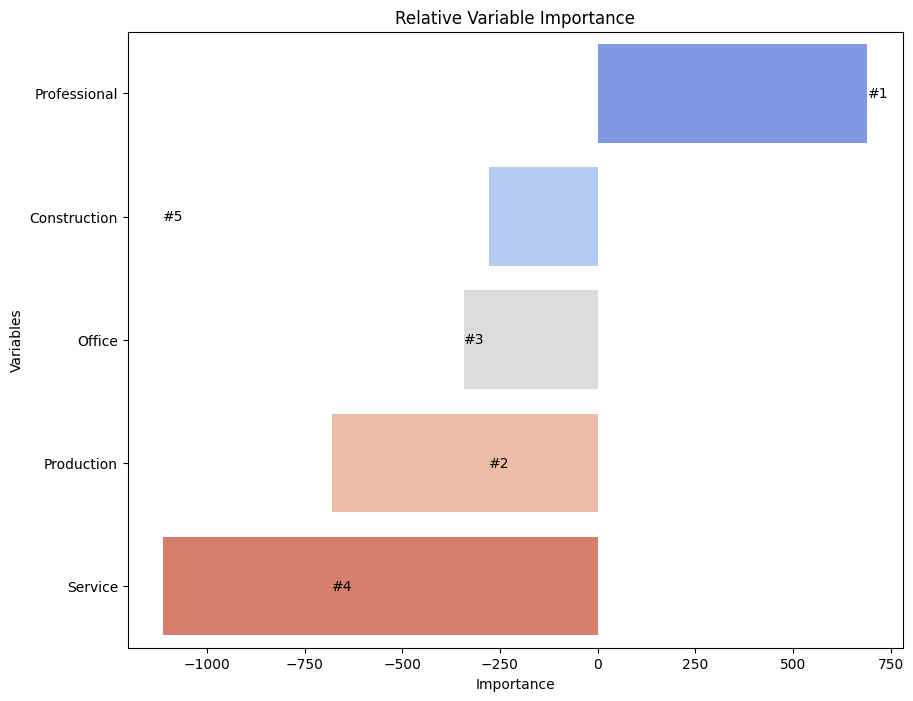

In [22]:
plot_importance(var_importance)

In [23]:
# Dự đoán cho tập kiểm tra
pred = model.predict(X_test)

# In ra console các giá trị dự đoán
print(pred)

[49280.71383334 44170.03172079 46017.66314124 ... 63839.83625725
 18122.92962609 54272.53969829]


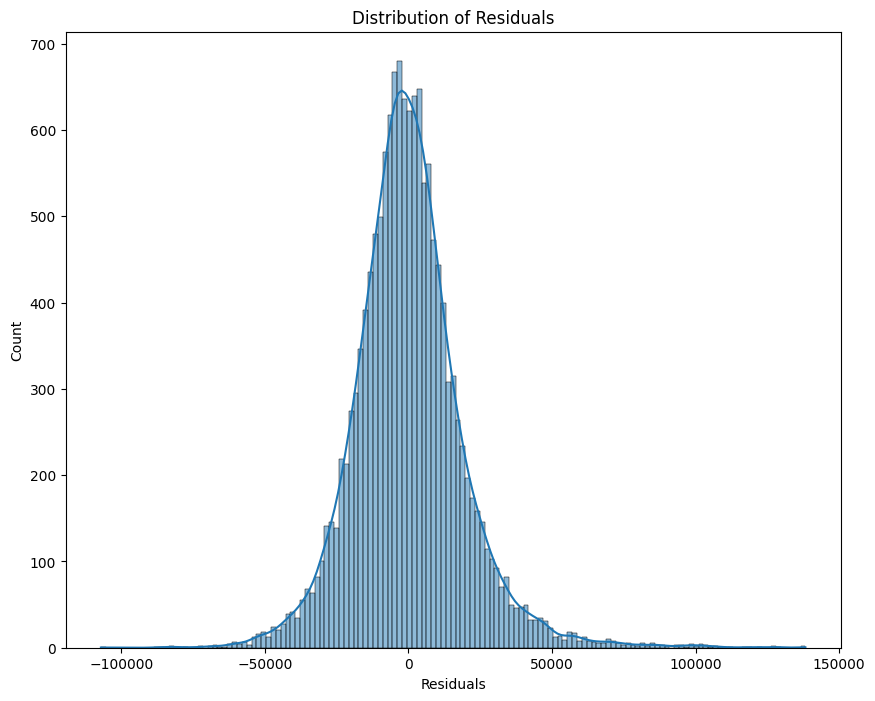

In [24]:
# Vẽ biểu đồ phân phối phần dư
residuals = y_test - pred
plt.figure(figsize=(10, 8))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

In [25]:
# Tính toán lỗi
error = pred - y_test

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE:", rmse)

RMSE: 19044.95565456754


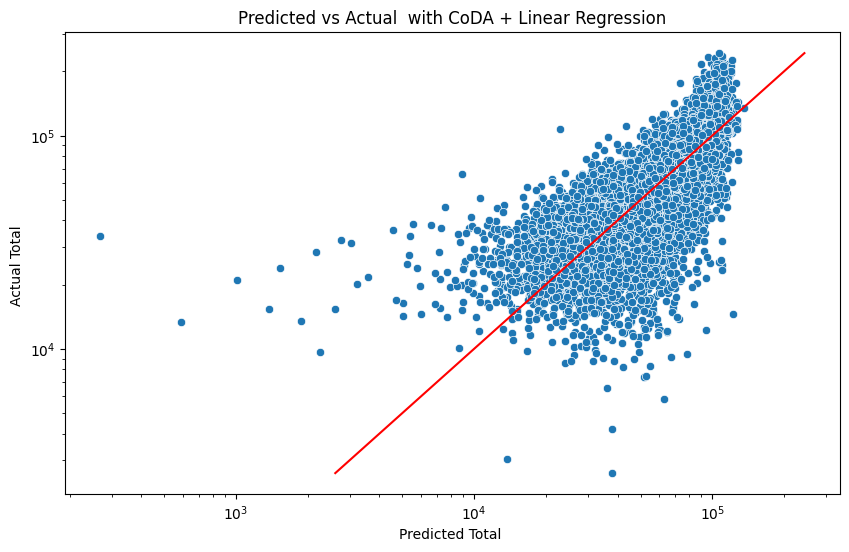

In [26]:
# Plot the predictions (on the x-axis) against the outcome (cty) on the test data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Total ')
plt.ylabel('Actual Total ')
plt.title('Predicted vs Actual  with CoDA + Linear Regression')
plt.show()